In [1]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime


In [2]:
# reading dataset

df = pd.read_csv('/home/pedro/Desktop/autoprognosis/code_v6/INFLUD-21-09-2020.csv',sep=';',encoding = "ISO-8859-1")

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)

/home/pedro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,60,62,63,64,92,94,108,117,121,123) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/pedro/anaconda3/lib/python3.7/site-packages/ipyker

(242679, 154)


In [3]:
# Pre-processing time variable

df['time'] = pd.to_datetime(df['DT_ENCERRA'], format='%d/%m/%Y',errors ='coerce').subtract(pd.to_datetime(df['DT_SIN_PRI'], format='%d/%m/%Y', errors ='coerce'))
df['time'] = df['time']/ np.timedelta64(1, 'D')


In [4]:
# To identifying public and private hospital

df_public = pd.read_csv('/home/pedro/Desktop/autoprognosis/Archive-SUS/SUS-SIM.txt', sep='\t')
df_private = pd.read_csv('/home/pedro/Desktop/autoprognosis/Archive-SUS/SUS-NAO.txt', sep='\t')

public  =  set(df_public.iloc[:,0])
#print(len(public))

private  =  set(df_private.iloc[:,0])
#print(len(private))


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0

print(df['HEALTH_SYSTEM'].value_counts())
print(df['HEALTH_SYSTEM'].shape)

print(df['CO_UNI_NOT'].isnull().sum())


1.0    180697
0.0     49930
Name: HEALTH_SYSTEM, dtype: int64
(242679,)
0


In [5]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/Desktop/code/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1


44
1890
2233
1367
32


In [6]:
# Constraint on dataset: We only analyze people with evolution, IDHM and Health system outcomes

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)

/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(230621, 157)


In [7]:
# Selecting people from North with COVID-19
df_N = df[df['PCR_SARS2']==1][df['HOSPITAL']==1]\
[(df['SG_UF_NOT']=='RO')|(df['SG_UF_NOT']=='TO')|(df['SG_UF_NOT']=='AM')|(df['SG_UF_NOT']=='RR')\
|(df['SG_UF_NOT']=='AC')|(df['SG_UF_NOT']=='PA')|(df['SG_UF_NOT']=='AP')]


# Selecting people from Northeast with COVID-19
df_NE = df[df['PCR_SARS2']==1][df['HOSPITAL']==1]\
[(df['SG_UF_NOT']=='RN')|(df['SG_UF_NOT']=='PE')|(df['SG_UF_NOT']=='SE')| (df['SG_UF_NOT']=='CE')\
|(df['SG_UF_NOT']=='PB')| (df['SG_UF_NOT']=='BA')|(df['SG_UF_NOT']=='AL')| (df['SG_UF_NOT']=='PI')\
|(df['SG_UF_NOT']=='MA')]


# Selecting people from Center-West with COVID-19
df_CO = df[df['PCR_SARS2']==1][df['HOSPITAL']==1]\
[(df['SG_UF_NOT']=='DF')|(df['SG_UF_NOT']=='MS')|(df['SG_UF_NOT']=='GO')| (df['SG_UF_NOT']=='MT')]


# Selecting people from Southest with COVID-19
df_SE = df[df['PCR_SARS2']==1][df['HOSPITAL']==1]\
[(df['SG_UF_NOT']=='SP') | (df['SG_UF_NOT']=='RJ')|(df['SG_UF_NOT']=='ES')|(df['SG_UF_NOT']=='MG')]


# Selecting people from South with COVID-19
df_S = df[df['PCR_SARS2']==1][df['HOSPITAL']==1]\
[(df['SG_UF_NOT']=='RS')|(df['SG_UF_NOT']=='SC')|(df['SG_UF_NOT']=='PR')]


print('confirmed data in North :',df_N.shape[0])
print('confirmed data in Northeast:',df_NE.shape[0])
print('confirmed data in Center-West:',df_CO.shape[0])
print('confirmed data in Southest:',df_SE.shape[0])
print('confirmed data in South:',df_S.shape[0])

confirmed data in North : 12256
confirmed data in Northeast: 42305
confirmed data in Center-West: 18617
confirmed data in Southest: 128752
confirmed data in South: 28691


/home/pedro/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


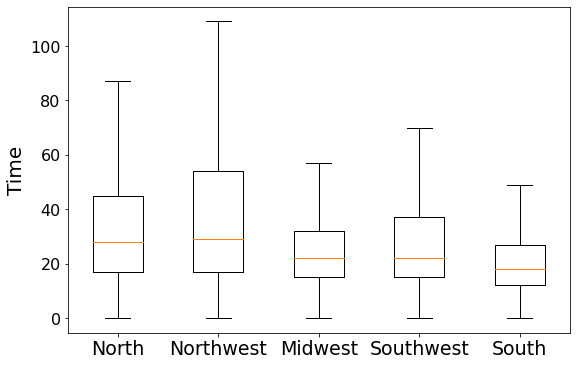

In [8]:

labels = ['North', 'Northwest', 'Midwest', 'Southwest', 'South']


fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)


all_data = [df_N['time'].dropna(), df_NE['time'].dropna(),\
df_CO['time'].dropna(),df_SE['time'].dropna(),\
df_S['time'].dropna()]



# Create the boxplot
bp = ax.boxplot(all_data , showfliers=False, labels=labels, sym='k+')


ax.set_xticklabels(labels=labels,fontsize=19)
plt.yticks(fontsize=16)
plt.setp(bp['fliers'], markersize=3.0)
plt.ylabel('Time',fontsize=20)
plt.savefig('boxplot_time.pdf')
plt.show()
plt.close()